In [1]:
import numpy as np
#from plotly.offline import download_plotlyjs, init_notebook_mode,plot,iplot
#init_notebook_mode(connected=True)
#import plotly.graph_objs as go
import matplotlib.pyplot as plt
%matplotlib inline

model_name = "DRAM_classify_blobs_2"
data_directory = "data/" + model_name + "/"

num_runs = 10
iter_list = [2000000]
glimpse_list = [9]
max_blobs = 15
min_blobs = 1

num_iters = len(iter_list)
num_glimpses = len(glimpse_list)
output_size = max_blobs - min_blobs + 1
chist = np.load(data_directory + 'choice_hist.npy')[:,11,2,:10,:10]
cm = np.load(data_directory + 'choice_msdcv.npy')[:,11,2,:10,:10]

cmus = cm[:,:,0] # mean
csds = cm[:,:,1] # sd
ccvs = cm[:,:,2] # cv

In [2]:
# take the averages across the 10 runs
chist_mu = np.mean(chist,axis=0)
cmus_mu = np.mean(cmus,axis=0)
cmus_min = np.min(cmus,axis=0)
cmus_max = np.max(cmus,axis=0)
csds_mu = np.mean(csds,axis=0)
csds_min = np.min(csds,axis=0)
csds_max = np.max(csds,axis=0)
ccvs_mu = np.mean(ccvs,axis=0)
ccvs_min = np.min(ccvs,axis=0)
ccvs_max = np.max(ccvs,axis=0)

In [3]:
def plot_hists(matrix,i_ind):
    fig, ax = plt.subplots(9,num_glimpses,sharex=True, sharey=True,figsize=(4,8))
    x = range(1, 10)
    fig.tight_layout()
    plt.xticks(range(1, 10))
    for c in range(num_glimpses):
        tstr = 'I = ' + str(iter_list[i_ind]) + ', G = ' + str(glimpse_list[c])
        ax[0].set_title(tstr)
        for i in range(9):
            ax[i].plot(x,matrix[i,:9])
    plt.show()

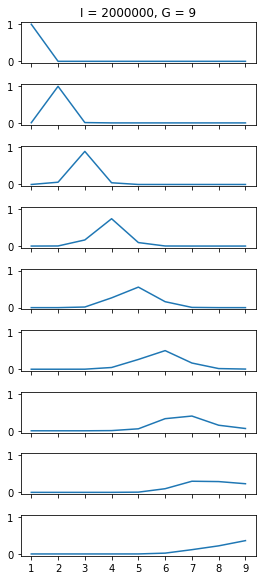

In [4]:
iter_idx = num_iters - 1
plot_hists(chist_mu[:,:],iter_idx)

## Run Linear Regression

In [5]:
import scipy.stats as st

def get_linreg(cvals):
    """Get lines of best fit."""
    
    slopes = np.zeros(num_runs)
    intercepts = np.zeros(num_runs)
    r_vals = np.zeros(num_runs)

    for run in range(num_runs):
        slopes[run], intercepts[run], r_vals[run], _, _ = st.linregress(range(1,10), cvals[run,:9])
    
    return slopes, intercepts, r_vals

In [6]:
cmus_slopes, cmus_intercepts, cmus_rvals = get_linreg(cmus)
csds_slopes, csds_intercepts, csds_rvals = get_linreg(csds)
ccvs_slopes, ccvs_intercepts, ccvs_rvals = get_linreg(ccvs)

# Visualize

# for i in range(num_runs):
#     plt.plot(range(1,10), cmus[i,:9], 'o', label='original data')
#     plt.plot(range(1,10), cmus_intercepts[i] + cmus_slopes[i]*range(1,10), 'r', label='fitted line')
#     plt.legend()
#     plt.show()

# for i in range(num_runs):
#     plt.plot(range(1,10), csds[i,:9], 'o', label='original data')
#     plt.plot(range(1,10), csds_intercepts[i] + csds_slopes[i]*range(1,10), 'r', label='fitted line')
#     plt.legend()
#     plt.show()
    
# for i in range(num_runs):
#     plt.plot(range(1,10), ccvs[i,:9], 'o', label='original data')
#     plt.plot(range(1,10), ccvs_intercepts[i] + ccvs_slopes[i]*range(1,10), 'r', label='fitted line')
#     plt.legend()
#     plt.show()

In [7]:
import math

def get_CI(vals):
    """Get the 95% confidence intervals."""

    mean = np.mean(vals)
    sd = np.std(vals)
    hw = 1.96*sd/math.sqrt(9)
#     print("CI: (" + str(mean - hw) + ", " + str(mean + hw) + ")")
    return round(mean, 2), round(hw, 2)

# Confidence Intervals

## Mean Choice

### Slope

In [8]:
get_CI(cmus_slopes)

(0.97999999999999998, 0.02)

### Intercept

In [9]:
get_CI(cmus_intercepts)

(0.02, 0.040000000000000001)

### R-Values

In [10]:
get_CI(cmus_rvals)

(1.0, 0.0)

## Standard Deviation of Choice

### Slope

In [11]:
get_CI(csds_slopes)

(0.16, 0.01)

### Intercept

In [12]:
get_CI(csds_intercepts)

(-0.14999999999999999, 0.02)

### R-Values

In [13]:
get_CI(csds_rvals)

(0.98999999999999999, 0.01)

## Coefficient of Variation of Choice

### Slope

In [14]:
get_CI(ccvs_slopes)

(0.01, 0.0)

### Intercept

In [15]:
get_CI(ccvs_intercepts)

(0.040000000000000001, 0.01)

### R-Values

In [16]:
get_CI(ccvs_rvals)

(0.79000000000000004, 0.029999999999999999)

# Final DRAM Chart

In [17]:
def plot_stats(title, cmus, csds, ccvs):
    """Make the table of graphs."""
    
    fig, ax = plt.subplots(1,3,sharex=True, sharey=True,figsize=(12,4))
    plt.xticks(range(1,10))
    x = range(1,10)    
    
    def plot_graph(tstr, ax, col, ylim, cvals):
        """Plot a single graph."""
        
        # take the averages across the 10 runs
        smu = np.mean(cvals,axis=0)
        smin = np.min(cvals,axis=0)
        smax = np.max(cvals,axis=0)
        
        ax.set_title(tstr)
        ax.set_ylim(top=ylim)
        ax.yaxis.set_label_position('left')
        ax.yaxis.set_ticks_position('left')
        ax.plot(x,smu[:9],'k-')
        ax.set_xlabel("Stimulus Numerosity")
    
        slopes, intercepts, rvals = get_linreg(cvals)
        S_mean, S_hw = get_CI(slopes)
        I_mean, I_hw = get_CI(intercepts)
        R_mean, R_hw = get_CI(rvals)

        ax.text(.25, .75, '$S: ' + str(S_mean) + ' \pm ' + str(S_hw) + \
                '$ \n $I: ' + str(I_mean) + ' \pm ' + str(I_hw) + \
                '$ \n $R: ' + str(R_mean) + ' \pm ' + str(R_hw) + '$',
            horizontalalignment='center',
            verticalalignment='center',
            transform=ax.transAxes)

        ax.fill_between(x,smin[:9],smax[:9], facecolor='orange')
        
    plot_graph("Mean Choice", ax[0], 0, 10, cmus)
    plot_graph("Standard Deviation", ax[1].twinx(), 1, 3, csds)
    plot_graph("Coefficient of Variation", ax[2].twinx(), 2, .5, ccvs)
    fig.tight_layout()

    fig.suptitle(title, fontsize=16)
    fig.subplots_adjust(top=0.8)

    plt.show()

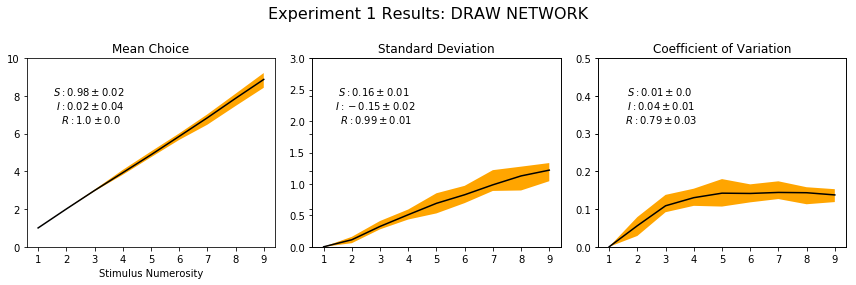

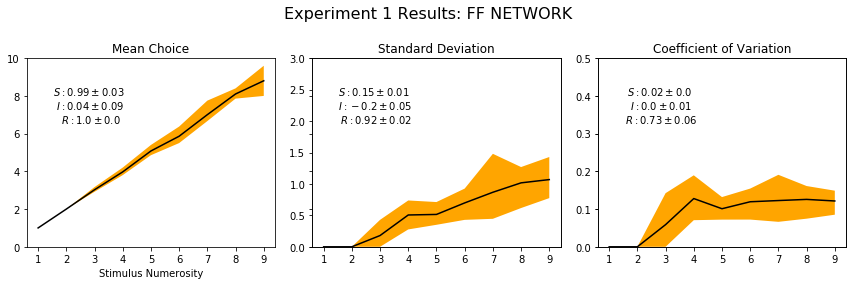

In [19]:
model_name = "DRAM_classify_blobs_2"
data_directory = "data/" + model_name + "/"
cm = np.load(data_directory + 'choice_msdcv.npy')[:,11,2,:10,:10]
cmus = cm[:,:,0] # mean
csds = cm[:,:,1] # sd
ccvs = cm[:,:,2] # cv
plot_stats("Experiment 1 Results: DRAW NETWORK", cmus, csds, ccvs)

model_name = "DRAM_onelayer"
data_directory = "data/" + model_name + "/"
cm = np.load(data_directory + 'choice_msdcv.npy')[:,19,:10,:10]
cmus = cm[:,:,0] # mean
csds = cm[:,:,1] # sd
ccvs = cm[:,:,2] # cv
plot_stats("Experiment 1 Results: FF NETWORK", cmus, csds, ccvs)